[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\梁晨\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\梁晨\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Logistic Regression - Accuracy: 0.7700, F1-score: 0.7682
Naive Bayes - Accuracy: 0.7750, F1-score: 0.7750
Support Vector Machine - Accuracy: 0.7700, F1-score: 0.7690
Random Forest - Accuracy: 0.6950, F1-score: 0.6866


C:\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:58:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.6950, F1-score: 0.6911

Best model: Naive Bayes
Best Accuracy: 0.7750, Best F1-score: 0.7750
Logistic Regression - Accuracy: 0.7700, F1-score: 0.7682
Naive Bayes - Accuracy: 0.7750, F1-score: 0.7750
Support Vector Machine - Accuracy: 0.7700, F1-score: 0.7690
Random Forest - Accuracy: 0.6950, F1-score: 0.6866


C:\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.6950, F1-score: 0.6911


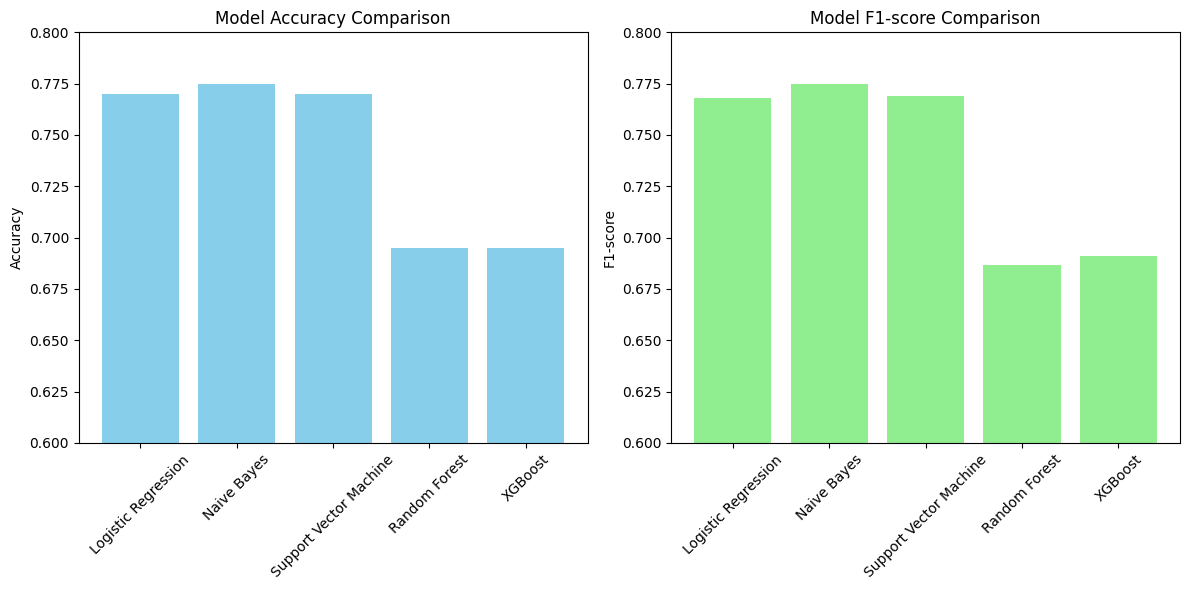


=== Performance Summary ===
| Model                  |   Accuracy |   F1-score |
|:-----------------------|-----------:|-----------:|
| Logistic Regression    |     0.7700 |     0.7682 |
| Naive Bayes            |     0.7750 |     0.7750 |
| Support Vector Machine |     0.7700 |     0.7690 |
| Random Forest          |     0.6950 |     0.6866 |
| XGBoost                |     0.6950 |     0.6911 |


In [3]:
import numpy as np
import pandas as pd
import re
import nltk
import joblib
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

nltk.download('stopwords')
nltk.download('wordnet')

# 读取数据
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)

# 数据清理与预处理
lemmatizer = WordNetLemmatizer()
corpus = []

for review in dataset['Review']:
    review = re.sub(r"http\S+|www\S+|https\S+", '', review, flags=re.MULTILINE)  # 移除URLs
    review = re.sub(r'[^a-zA-Z]', ' ', review)  # 仅保留字母
    review = review.lower().split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words('english')]
    corpus.append(' '.join(review))

# 使用 TF-IDF 特征提取
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# 保存 Vectorizer 以备后用
joblib.dump(vectorizer, 'vectorizer_reviews_tfidf.joblib')

# 划分训练集和测试集（80% 训练, 20% 测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义模型列表
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Naive Bayes', MultinomialNB()),
    ('Support Vector Machine', SVC(kernel='linear', C=1.0)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# 训练和评估模型
best_model = None
best_f1_score = 0
best_accuracy = 0

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{model_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}')
    
    # 使用 F1-score 作为选择标准
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model_name
        best_accuracy = accuracy

print(f'\nBest model: {best_model}')
print(f'Best Accuracy: {best_accuracy:.4f}, Best F1-score: {best_f1_score:.4f}')

results = {
    'Model': [],
    'Accuracy': [],
    'F1-score': []
}

# 训练和评估模型（修改原有循环部分）
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 存储结果
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['F1-score'].append(f1)
    
    print(f'{model_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}')

# 转换为DataFrame便于绘图
results_df = pd.DataFrame(results)

# --- 绘制柱状图 ---
plt.figure(figsize=(12, 6))

# 1. 准确率对比
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylim(0.6, 0.8)  # 固定Y轴范围便于对比
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

# 2. F1-score对比
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['F1-score'], color='lightgreen')
plt.title('Model F1-score Comparison')
plt.ylim(0.6, 0.8)
plt.xticks(rotation=45)
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()

# --- 打印表格 ---
print("\n=== Performance Summary ===")
print(results_df.to_markdown(index=False, floatfmt=".4f"))